Notebook purpose

- Explore entropy scores

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config

import entropy.helpers.aws as ha
import entropy.helpers.helpers as hh 
import entropy.helpers.data as hd
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile='3di')

In [2]:
def inspect(df, nrows=2):
    print('({:,}, {})'.format(*df.shape))
    display(df.head(nrows))
    
@hh.timer
def reader(fp):
    return ha.read_parquet(fp)

# Load data

In [3]:
SAMPLE = '777'
fp = f's3://3di-project-entropy/entropy_{SAMPLE}.parquet'
dfs = reader(fp)
inspect(dfs)

Time for reader         : 3.38 seconds
(57,509, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_tag
0,688261,2012-01-03,777,400.00,mdbremoved,NaN,transfers,transfers,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,364.220001,non merchant mbl,transfers,other account,other account,u,201201,0.0,-1542.99646,24319.220881,3.531665
1,688264,2012-01-03,777,10.27,9572 30dec 11 mcdonalds restaurant winwick road gb,mcdonalds,spend,services,0.0,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2015-03-19,True,364.220001,mcdonalds,dining and drinking,NaN,dining and drinking,u,201201,0.0,-1542.99646,24319.220881,3.531665


In [4]:
SAMPLE = 'XX7'
# fp = f'~/tmp/entropy_{SAMPLE}.parquet'
fp = f's3://3di-project-entropy/entropy_{SAMPLE}.parquet'
df = reader(fp)
inspect(df)

Time for reader         : 3.04 minutes
(6,791,894, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_tag
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948


# Cross-sectional entropy

## Overview

txns_breakdowns_and_entropy.png written.


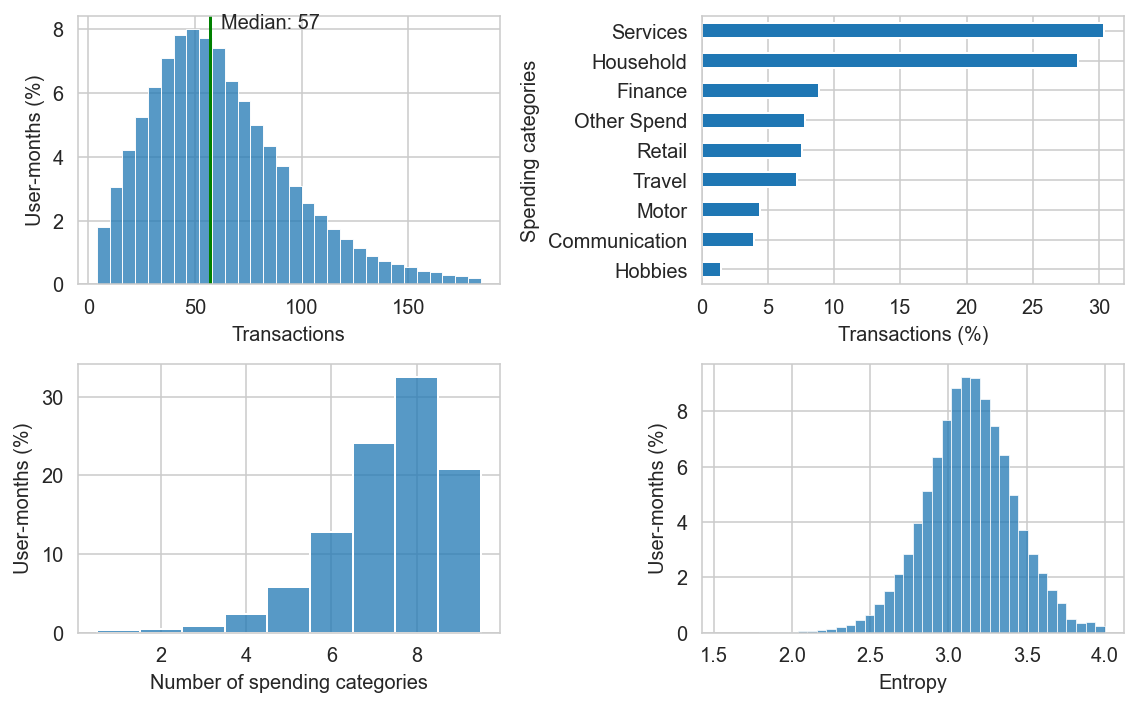

In [5]:
data = df
write = True

figs.txns_breakdowns_and_entropy(data, write=write)

## Case studies

In [28]:
def make_spend_data(df):
    """Retains only spending transactions."""
    df = df[df.tag_group.eq('spend')].copy()
    df['tag'] = df.tag.cat.remove_unused_categories()
    return df

def entropy_pct_case_study(df, pct):
    """Returns first user-month with entropy score at specified percentile."""
    pct_val = np.nanpercentile(df.entropy_tag, pct)
    pct_data = df[df.entropy_tag.eq(pct_val)]
    pct_data = pct_data.set_index(['ym', 'user_id'])
    first_user_month = pct_data.index.unique()[0]
    return pct_data.loc[first_user_month].reset_index()
    
def spend_breakdown(df, ax=None):
    """Plots breakdown of spending transactions across tags."""
    spend = df[df.tag_group.eq('spend')].copy()
    spend.tag.value_counts(ascending=True, normalize=True).plot(kind='barh', yticks=None, ax=ax)
    
def entropy_pct_case_studies(df, percentiles=None, **kwargs):
    """Shows spend txns breakdown for entropy percentiles sample users."""
    if percentiles is None:
        percentiles = [10, 50, 90]
    num_plots = len(percentiles)
    spend_data = make_spend_data(df)
    fig, ax = plt.subplots(1, num_plots, **kwargs)
    for i, pct in enumerate(percentiles):
        data = entropy_pct_case_study(spend_data, pct)
        entropy = data.entropy_tag[0]
        title = f'{pct}th percentile (H = {entropy:.1f})'
        spend_breakdown(data, ax=ax[i])
        ax[i].set(title=title)
        ax[i].get_yaxis().set_ticks([])
    return fig, ax

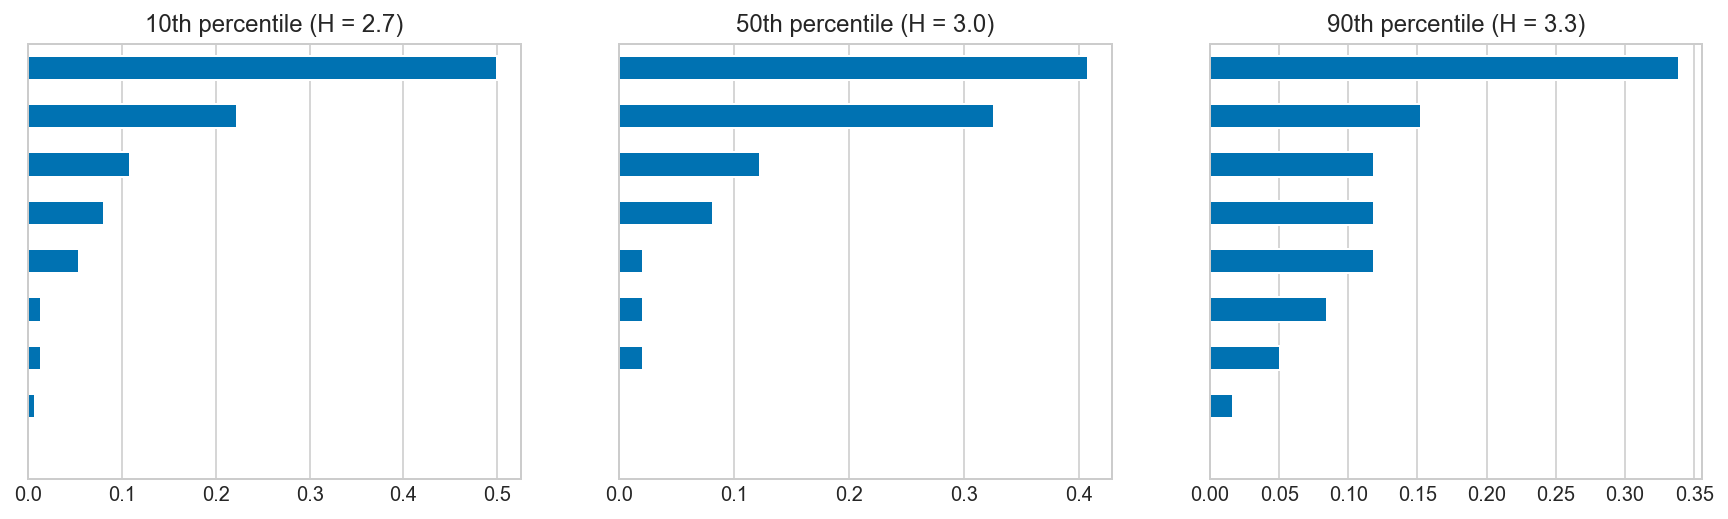

In [29]:
fig, ax = entropy_pct_case_studies(df, figsize=(15, 4))

# Entropy across time

In [ ]:
df[df.tag_group.eq('spend')].groupby(['user_id', 'ym']).tag.value_counts()

user_id  ym      tag          
777      201201  household        7
                 finance          6
                 other_spend      6
                 services         5
                 motor            2
                                 ..
587177   202007  motor            7
                 hobbies          6
                 other_spend      3
                 communication    2
                 retail           2
Name: tag, Length: 49934, dtype: int64

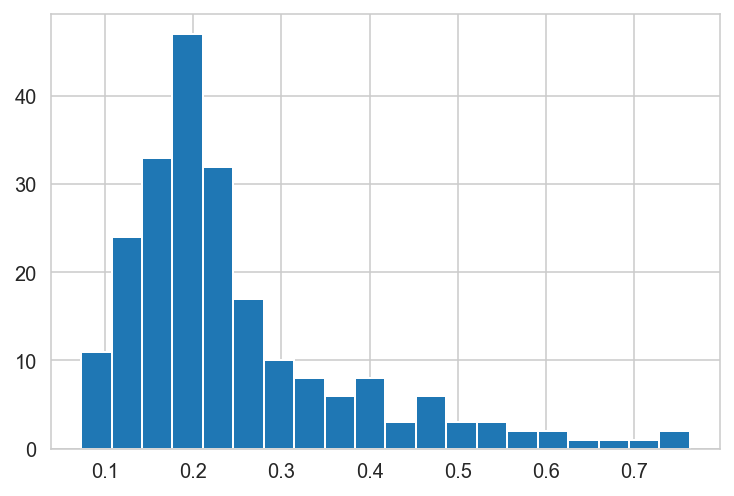

In [67]:
data.groupby('user_id').entropy_tag.std().hist(bins=20);

Patterns year-to-year (would expect to be stable)

<AxesSubplot:xlabel='ym', ylabel='entropy_tag'>

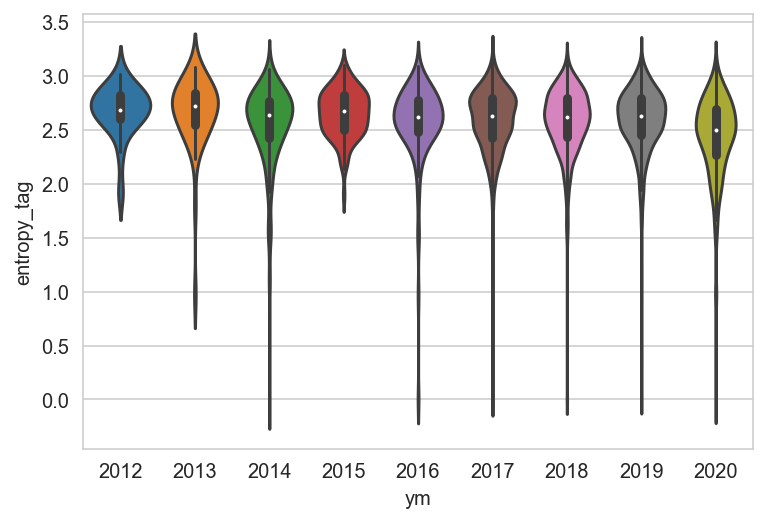

In [73]:
sns.violinplot(data=data, x=data.ym // 100, y='entropy_tag')